In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
from torchvision import transforms, datasets, models
from torch.amp import autocast, GradScaler
from trainning.fusion_dataset import FusionDataset
import numpy as np
import matplotlib.pyplot as plt
from diffusers import AutoencoderKL, UNet2DConditionModel, DPMSolverMultistepScheduler
from transformers import CLIPModel
from PIL import Image

c:\Users\HanDong\Documents\Study\Semester 6 - OJT\image_fusion_generation\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class PretrainedCNNBranch(nn.Module):
    def __init__(self, feature_dim=128):
        super().__init__()
        net = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        layers = list(net.children())[:-2]  # keep up to last conv feature map
        self.backbone = nn.Sequential(*layers)  # (B,512,H/32,W/32)
        feat_channels = 512

        # Projection
        self.proj = nn.Conv2d(feat_channels, feature_dim, kernel_size=1)

    def forward(self, x):
        feat = self.backbone(x)   # (B, feat_channels, H', W')
        feat = self.proj(feat)    # (B, feature_dim, H', W')
        return feat


class CLIPViTBranch(nn.Module):
    def __init__(self, feature_dim=128):
        super().__init__()
        self.clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", use_safetensors=True)

        # Projection to match UNet cross-attention dim
        self.proj = nn.Linear(self.clip.config.vision_config.hidden_size, feature_dim)

    def forward(self, x):
        # x: [B,3,H,W], expected 224x224 for CLIP
        x_resized = F.interpolate(x, size=(224,224), mode="bicubic", align_corners=False)
        outputs = self.clip.vision_model(x_resized)
        feat = outputs.last_hidden_state  # (B, seq_len, D)
        feat = self.proj(feat)            # (B, seq_len, feature_dim)
        return feat


class HybridEncoder(nn.Module):
    def __init__(self, feature_dim=128, unfreeze_resnet=False, unfreeze_clip=False):
        super().__init__()
        self.feature_dim = feature_dim
        self.cnn_branch  = PretrainedCNNBranch(feature_dim, unfreeze_last_block=unfreeze_resnet)
        self.clip_branch = CLIPViTBranch(feature_dim=feature_dim, unfreeze_last_block=unfreeze_clip)

        # Fusion head (trainable)
        self.fuse = nn.Sequential(
            nn.Linear(feature_dim, feature_dim),
            nn.LayerNorm(feature_dim),
            nn.ReLU(inplace=True)
        )

    def forward(self, img1, img2):
        # Local features from CNN
        feat_cnn = self.cnn_branch(img1)        # (B,128,H',W')
        feat_cnn_flat = feat_cnn.flatten(2).transpose(1,2)  # (B,HW,128)

        # Global features from CLIP
        feat_clip = self.clip_branch(img2)      # (B,seq,128)

        # Concatenate and fuse
        fused = torch.cat([feat_cnn_flat, feat_clip], dim=1) # (B,HW+seq,128)
        fused = self.fuse(fused)
        return fused

class HybridEncoder(nn.Module):
    def __init__(self, feature_dim=128):
        super().__init__()
        self.cnn_branch  = PretrainedCNNBranch(feature_dim)
        self.clip_branch = CLIPViTBranch(feature_dim=feature_dim)
        self.feature_dim = feature_dim

    def forward(self, img1, img2):
        # Local features from CNN (content)
        feat_cnn = self.cnn_branch(img1)   # (B,128,H',W')

        # Global features from CLIP (style)
        feat_clip = self.clip_branch(img2) # (B, seq,128)

        # Flatten CNN feat
        feat_cnn_flat = feat_cnn.flatten(2).transpose(1,2)  # (B,HW,128)

        # Fuse by concatenation
        fused = torch.cat([feat_cnn_flat, feat_clip], dim=1) # (B,HW+seq,128)
        return fused
    

class Adapter(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim=512):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.fc(x)
    

class FusionSDTurboModel(nn.Module):
    def __init__(self, encoder: nn.Module,
                 pretrained_model="stabilityai/sd-turbo",
                 device="cuda"):
        super().__init__()
        self.device = device
        self.encoder = encoder

        # Load pretrained SD-Turbo components
        self.vae = AutoencoderKL.from_pretrained(pretrained_model, subfolder="vae").to(device)
        self.unet = UNet2DConditionModel.from_pretrained(pretrained_model, subfolder="unet").to(device)

        # Recommended SD scheduler
        self.scheduler = DPMSolverMultistepScheduler.from_pretrained(pretrained_model, subfolder="scheduler")

        # Freeze UNet + VAE
        for p in self.vae.parameters():
            p.requires_grad = False
        for p in self.unet.parameters():
            p.requires_grad = False
        for p in self.encoder.parameters():
            p.requires_grad = False

        # Cross-attention projection
        cross_dim = self.unet.config.cross_attention_dim
        self.adapter = Adapter(encoder.feature_dim, cross_dim)

        # Resize inputs to 256x256
        self.upsample = transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BICUBIC)

        # Latent scaling factor
        self.latent_scale = self.vae.config.scaling_factor

    def encode_latents(self, x):
        latents = self.vae.encode(x).latent_dist.sample()
        return latents * self.latent_scale

    def decode_latents(self, latents):
        latents = latents / self.latent_scale
        imgs = self.vae.decode(latents).sample
        return imgs

    def forward(self, img1, img2, timesteps):
        img1 = self.upsample(img1)
        img2 = self.upsample(img2)

        with torch.amp.autocast(device_type=self.device, dtype=torch.float16):
            # Encode & fuse
            fused_feats = self.encoder(img1, img2)   # [B,HW,C]
            cond = self.adapter(fused_feats)         # [B,HW,cross_dim]

            # Encode latents
            latents = self.encode_latents(img1)

            # Add noise
            noise = torch.randn_like(latents)
            noisy_latents = self.scheduler.add_noise(latents, noise, timesteps)

            # Predict noise (UNet frozen)
            noise_pred = self.unet(noisy_latents, timesteps, encoder_hidden_states=cond).sample

            # Optional reconstruction (not used for training loss, but useful for debugging)
            denoised_latents = latents - noise_pred
            out = self.decode_latents(denoised_latents)

        return noise_pred, noise, out

    # For inference only
    @torch.no_grad()
    def generate(self, img1, img2, num_inference_steps=30):
        self.eval()
        img1 = self.upsample(img1)
        img2 = self.upsample(img2)

        # Encode & fuse
        fused_feats = self.encoder(img1, img2)
        cond = self.adapter(fused_feats) 

        # Start from random noise in latent space
        latent_shape = (img1.size(0), self.unet.in_channels, 32, 32)  # 256→32 scaling
        latents = torch.randn(latent_shape, device=self.device)

        # Prepare scheduler
        self.scheduler.set_timesteps(num_inference_steps, device=self.device)

        # Iterative denoising
        for t in self.scheduler.timesteps:
            with torch.amp.autocast(device_type=self.device, dtype=torch.float16):
                noise_pred = self.unet(latents, t, encoder_hidden_states=cond).sample
            latents = self.scheduler.step(noise_pred, t, latents).prev_sample

        # Decode to image space
        imgs = self.decode_latents(latents)
        return imgs

In [3]:
def train(model, dataloader, device="cuda", epochs=10, lr=2e-5):
    opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scaler = GradScaler(device) 

    for epoch in range(epochs):
        model.train()
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for img1, img2 in pbar:
            img1, img2 = img1.to(device), img2.to(device)

            timesteps = torch.randint(
                0, model.scheduler.config.num_train_timesteps, (img1.size(0),), device=device, dtype=torch.long
            )

            # Mixed precision forward
            with autocast(device, dtype=torch.float16):
                noise_pred, noise, _ = model(img1, img2, timesteps)
                loss = F.mse_loss(noise_pred.float(), noise.float())

            # Backward + optimizer step
            opt.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            pbar.set_postfix({"loss": loss.item()})
        torch.save(model.state_dict(), f"checkpoint/trainUNet_FusionSDTurboModel_epoch{epoch+1}.pt")

In [3]:
def to_numpy_img(x):
    x = x.detach().cpu().float()  # ensure float32
    x = (x.clamp(-1, 1) + 1) / 2  # [-1,1] -> [0,1]
    x = x.permute(0, 2, 3, 1).numpy()  # [B,H,W,3]
    return x

def show_test_sample(model, dataloader, device="cuda", num_inference_steps=25):
    model.eval()
    img1, img2 = next(iter(dataloader))
    img1, img2 = img1[:1].to(device), img2[:1].to(device)

    with torch.no_grad():
        out = model.generate(img1, img2, num_inference_steps)

    # Convert all to numpy for plotting
    img1_np = to_numpy_img(img1)[0]
    img2_np = to_numpy_img(img2)[0]
    out_np  = to_numpy_img(out)[0]

    # Plot side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(img1_np); axes[0].set_title("Input 1"); axes[0].axis("off")
    axes[1].imshow(img2_np); axes[1].set_title("Input 2"); axes[1].axis("off")
    axes[2].imshow(out_np);  axes[2].set_title("Generated"); axes[2].axis("off")
    plt.show()

In [4]:
# Hyperparams
lr = 1e-4
batch_size = 4
num_epochs = 1
device = "cuda" if torch.cuda.is_available() else "cpu"

# Preprocessing
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

base_dataset = datasets.ImageFolder(root="data/afhq/train", transform=None)

# Use a subset for quick testing
subset_indices = np.random.choice(len(base_dataset), 1000, replace=False)
small_dataset = Subset(base_dataset, subset_indices)

fusion_dataset = FusionDataset(small_dataset, transform=transform)
fusion_loader = DataLoader(fusion_dataset, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)

encoder = HybridEncoder(feature_dim=128).to(device)
model = FusionSDTurboModel(encoder).to(device)


In [6]:
train(model, fusion_loader, device=device, epochs=num_epochs, lr=lr)

Epoch 1/1:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/1:   0%|          | 1/250 [00:51<3:34:01, 51.57s/it, loss=0.358]


OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 12.32 GiB is allocated by PyTorch, and 115.91 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

C:\Users\HanDong\AppData\Local\Temp\ipykernel_23688\719975997.py:176: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latent_shape = (img1.size(0), self.unet.in_channels, 32, 32)  # 256→32 scaling


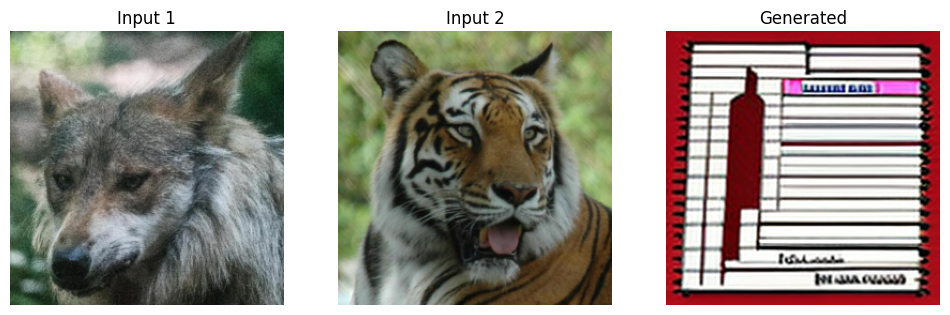

In [5]:
show_test_sample(model, fusion_loader, device, num_inference_steps=25)

C:\Users\HanDong\AppData\Local\Temp\ipykernel_9108\2596647766.py:108: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latent_shape = (img1.size(0), self.unet.in_channels, 32, 32)  # 256x256 → 32x32


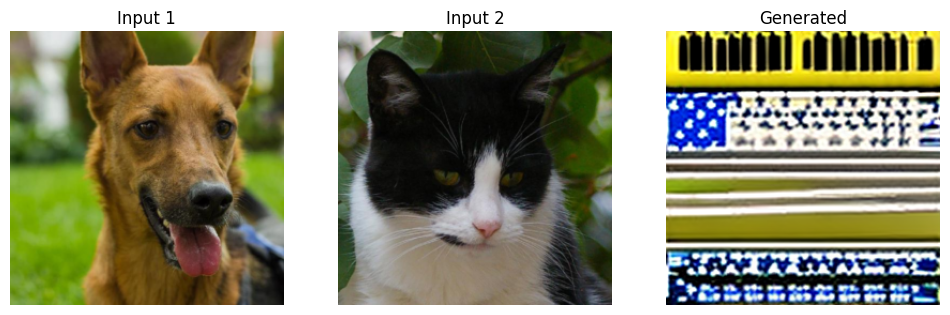

In [ ]:
show_test_sample(model, fusion_loader, device, num_inference_steps=25)

In [10]:
# # Free memory
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()